<img src="https://thediplomat.com/wp-content/uploads/2022/10/sizes/td-story-s-2/thediplomat_2022-10-19-193918.jpg" style="width:50%; display: block; margin-left: auto; margin-right: auto">
<table style="width:50%">
    <tr>
        <th>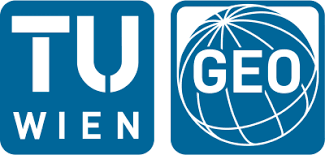</th>
        <th><img src="https://eodc.eu/wp-content/uploads/2018/10/EODC-Logo-Final.png"></th>
    </tr>
</table>

# DestinE Data Lake

The Destination Earth Data Lake (DEDL) combines such disparate data sources in one large virtual database. Moreover, this virtual database comes with a set of tools that facilitates the search for relevant resources as well as the analysis of data by performing computationally expensive operations near to the data source.

This Jupyter Notebook serves as an example of how the DEDL service could have helped with a disaster response assessment during the 2022 Pakistan flood.

## Infrastructure setup
<img src="./DEDL-Flood-UC-setup.jpg" style="width:75%; display: block; margin-left: auto; margin-right: auto">

# Use Case 1: Pakistan Flood 2022

A disaster management expert is called to assess what the flood risk of the Indus River plain is if heavy rainfall continuous in the next days.

To address this issue the expert has to access data from several resources, which includes sociographic information about human settlements as well as physical parameters such as rain intensity. Furthermore, model predictions help forecast forthcoming inundation of land. This multifaceted approach for flood risk mapping ensures efficient planning of mitigating measures, such as targeted evacuation plans. 

### Create Dask Clusters on Central Site and Bridge
Make use of DEDL client library to create Dask cluster on each site registered in the DEDL.
Default settings are:
- Docker image used for Dask scheduler and workers
- worker CPU and memory
- enabled autoscaling

In [ ]:
from dedl.services.stack import DaskCluster
from dask_gateway import Gateway

mycluster = DaskCluster(name="DEDLdemo")
user_auth = mycluster.login(username="christoph")
mycluster.create_cluster(authobj=user_auth)
mycluster.get_cluster_url()

## Access Data from DEDL Service

Using the DEDL client, data can be accessed from various services. In this example, data is retrieved from the EU-funded Copernicus Emergency Management Service ([CEMS](https://extwiki.eodc.eu/en/GFM)), the European Centre for Medium-Range Weather Forecasts ([ECMWF](https://www.ecmwf.int/en/about)), the Copernicus Digital Elevation Model ([COP-DEM)](https://spacedata.copernicus.eu/en/web/guest/collections/copernicus-digital-elevation-model)) and the Global Human Settlement ([GHS](https://ghsl.jrc.ec.europa.eu/index.php)) layer. 


- The CEMS catalogue is used to obtain **Global Flood Monitoring (GFM)** data. The GFM data product is a worldwide flood monitoring system which consists of microwave imaging data and is acquired by EU’s Copernicus Sentinel-1 satellites. Microwave imaging is a technique that is relatively unaffected by cloud cover and is especially sensitive to variations in near surface water content. This type of data has been successively employed to monitor flooding. The binary data consists of daily measurement with a $20\,\text{m}$ by $20\,\text{m}$ spatial resolution which indicate whether a pixel has been flooded or not.
- The ECMWF catalogue is used to obtain the multi-decadal **ERA5-Land** dataset. This product is a reanalysis dataset that gives insight in the seasonal variation of land variables by averaging data over multiple decades with a $9\,\text{km}$ spatial resolution. The ERA5-Land data is retrieved to estimate the risk of further flooding for next several days by aggregating precipitation on a $20\,\text{m}$ by $20\,\text{m}$ spatial grid. This dataset is for demonstration purposes only, and will be replaced with a high resolution rainfall prediction dataset in the future.
- The **Copernicus DEM** data is used highlight the low-lying areas around the Indus river under the highest risk of flooding. This product consists of radar data acquired during the TanDEM-X mission between 2011 and 2015.
- The **Global Human Settelment (GHS) layer** is used to make a risk assessment for flooding of regional settlements. THE GHS-BUILT-S data provides a yearly measure of built-up surfaces on a $10\,\text{m}$ by $10\,\text{m}$ spatial grid. The product is a composite dataset consisting of Landsat (MSS, TM, ETM sensor) and Sentinel-2 imaging and represents the square meters of built-up surface in a cell.

Additionally, the DEDL service allows data uploads by the user. These capabilities of the DEDL services are examplified below.

In [ ]:
import xarray as xr
from usecase.parameters import Extent
from dedl.services import discovery


central_site_da = discovery.S3DataAccess("https://s3.dedl-centralsite.eodc.eu")
bridge_site_da = discovery.S3DataAccess("https://s3.dedl-bridge.eodc.eu")

xr.set_options(keep_attrs=True)
roi_extent = Extent(65, 21, 71, 31, crs='EPSG:4326')    # Pakistan

#### Read data located on central site
Location will be stored as attribute in the xarray object after loading the data.

##### GFM data

In [ ]:
floods_aug_18 = discovery.find_gfm_flood("2022-08-18", roi_extent, S3Access=central_site_da)
floods_aug_18

##### GHS

In [ ]:
built_surfaces = discovery.find_ghs_built(roi_extent, S3Access=central_site_da)
built_surfaces

#### Read data from data bridge

##### ERA5-Land

In [ ]:
from datetime import datetime
predicted_rain = discovery.find_predicted_rain(startdate=datetime(2022, 8, 18),
                                               enddate=datetime(2022, 8, 30),
                                               extent=roi_extent,
                                               S3Access=bridge_site_da)
predicted_rain

## Preprocess the Data
First the data needs to be preprocessed for visualisation to improve interpretability and also reduce the raw data size for faster interaction with the data.

This task is, however, computationally demanding and requires specialized IT infrastructure. The DEDL services are designed to cope with these computational limitations at the user's side by implementing distributed computation capabilities. This feature runs the task near to the source of the data. The user can therefore execute the script as if they would have performed it on their own local device (laptop, pc, or tablet). However, in reality, the computationally demanding tasks are executed at the high-performance computing facilities of DEDL.

In [ ]:
def preprocess_dataset(data_array: xr.DataArray, method: str):
    data_array = data_array.squeeze()
    steps = 500 // data_array.attrs["resolution"]
    coarsened = data_array.coarsen({'y': steps, 'x': steps}, boundary='trim')
    if method == 'median':
        data_array = (coarsened.median() > 0).astype('float32')
    elif method == 'mean':
        data_array = coarsened.mean()
    else:
        raise NotImplementedError(method)
    return data_array

In [ ]:
floods_aug_18_prep = preprocess_dataset(floods_aug_18, 'median')

In [ ]:
floods_aug_18_prep

In [ ]:
def preprocess_dataset_noresampling(data_array: xr.DataArray, method: str):
    data_array = data_array.squeeze()
    #steps = 500 // data_array.attrs["resolution"]
    #coarsened = data_array.coarsen({'y': steps, 'x': steps}, boundary='trim')
    if method == 'median':
        data_array = (data_array.median() > 0).astype('float32')
    elif method == 'mean':
        data_array = data_array.mean()
    else:
        raise NotImplementedError(method)
    return data_array

In [ ]:
floods_aug_18_prep_nr = preprocess_dataset(floods_aug_18, 'median')

In [ ]:
mycluster.cluster[floods_aug_18_prep.attrs["location"]].scale(5)
floods_aug_18_prep_nr = mycluster.client[floods_aug_18_prep.attrs["location"]].persist(floods_aug_18_prep_nr)

In [ ]:
floods_aug_18_prep_nr

In [ ]:
import hvplot.dask
 
def interact(darray):
    import datashader
    print(darray)
    return darray.hvplot.image(x='x', 
                               y='y', 
                               z='flood',
                               cmap='kbc_r',
                               width=600, 
                               height=400)
interact(floods_aug_18_prep_nr)

In [ ]:
import s3fs
s3_central = s3fs.S3FileSystem(
        anon=False,
        key='yc3tijUhz5wmHTkI',
        secret='JVjyK8HYf8xdejSgKxUVytdcq0cVMHIA',
        use_ssl=True,
        client_kwargs={
            'endpoint_url': "https://s3.dedl-centralsite.eodc.eu"
        }
    )
floods_aug_18_zarr = floods_aug_18_prep_nr.to_zarr(store=s3fs.S3Map(root=f"dedl-user/flood-20220818.zarr", s3=s3_central, check=False),
                                               mode="w", compute=False)

In [ ]:
mycluster.client[floods_aug_18_prep.attrs["location"]].compute(floods_aug_18_zarr, sync=True)

In [ ]:
floods_aug_18_ = mycluster.client[floods_aug_18_prep.attrs["location"]].compute(floods_aug_18_prep, sync=True)

In [ ]:
 floods_aug_18_

In [ ]:
import numpy as np
floods_aug_18 = floods_aug_18_.rio.reproject(f"EPSG:3857", nodata=np.nan)
floods_aug_18

In [ ]:
built_surfaces_prep = preprocess_dataset(built_surfaces, 'mean')
built_surfaces_prep_ = mycluster.client[built_surfaces.attrs["location"]].compute(built_surfaces_prep, sync=True)

In [ ]:
built_surfaces_prep_

## Inspect Data Flood Data

The DEDL services provides a quick view functionality that allows interactive inspection of the retrieved datasets. Here, the flood extent on 18<sup>th</sup> of August 2022 is compared to built-up surfaces (e.g. buildings, infrastructure, and other human-made structures) for 2022 to get an initial idea of which settlements might be at risk of flooding.

In [ ]:
import xarray as xr
from bokeh.models import CustomJSTickFormatter, FixedTicker
from holoviews import Image, element, Curve, extension, DynamicMap

extension('bokeh')

def render_flood_and_built_extent(flood: xr.DataArray, built: xr.DataArray, colorbar=True, **kwargs) -> None:
    built = built.rio.reproject_match(flood)
    combined = xr.zeros_like(flood, dtype=flood.dtype)
    combined.values = np.nanmax(np.stack([flood.values, ((built > 10) * 2).values]), axis=0)

    formatter = CustomJSTickFormatter(code='''
    return {0.33: 'other', 1.0 : 'flooded', 1.66 : 'built'}
    [tick]
    ''')
    ticker = FixedTicker(ticks=[0.33, 1.0, 1.66])

    color_opts = dict(
        cmap=["#D3D3D3", "rgb(0, 0, 128)", "#FF0000"],
        clipping_colors={'NaN': 'rgba(0, 0, 0, 0)'},
        colorbar=colorbar,
        colorbar_opts={'ticker': ticker, 'formatter': formatter}
    )

    flood_view = Image(combined).opts(**color_opts, **kwargs, xlabel="longitude", ylabel="latitude")
    street_view = element.tiles.StamenTonerRetina()
    return flood_view * street_view.opts(alpha=0.3)

def render_streetview(flood_view, **kwargs):
    street_view = element.tiles.CartoLight()
    return flood_view.opts(alpha=0, colorbar=False, **kwargs) * street_view

In [ ]:
floods_aug_18_view = render_flood_and_built_extent(floods_aug_18,
                                                   built_surfaces_prep_,
                                                   width=500, height=500,
                                                   title="A) Flood 2022-08-18 01:25:50 (GFM) \n & built-up surface 2022")
street_view =  render_streetview(floods_aug_18_view.Image.I.clone(), width=400, height=500, title="B) OpenStreetMap (CartoDB)")
floods_aug_18_view + street_view

*Fig1: A) Flood extent on 18<sup>th</sup> of August 2022 (GFM) and B) elevation in meters above mean sealevel (COP-DEM).*

## Predicting Rainfall

The rainfall dataset provides information that can be used to predict flood risk for the following days. Unfortunately, the rainfall data comes in a different resolution and projection, hence the export uses an algorithm to match the rainfall data to the flood data.

We will utilise the DEDL distributed processing platform again to perform the up-sampling algorithm developed by the University of Technology Vienna.

The predicted rainfall accumulated on a $500\,\text{m}$ by $500\,\text{m}$ grid resolution is then calculated on DEDL, as follows:

In [ ]:
def accum_rain_predictions(rain_data, startdate, enddate, extent):
    rain_ = rain_data.sel(time=slice(startdate, enddate),
                          latitude=slice(extent.max_y, extent.min_y),
                          longitude=slice(extent.min_x, extent.max_x))
    return rain_.cumsum(dim="time", keep_attrs=True)*1000

In [ ]:
acc_rain_ = accum_rain_predictions(predicted_rain, startdate=datetime(2022, 8, 18),
                                                  enddate=datetime(2022, 8, 30),
                                                  extent=roi_extent)

In [ ]:
acc_rain_

In [ ]:
acc_rain = mycluster.client[acc_rain_.attrs["location"]].compute(acc_rain_, sync=True)

In [ ]:
def acc_rain_reproject(rain):
    from rasterio.enums import Resampling
    rain.rio.write_nodata(0, inplace=True)
    rain.rio.write_crs('EPSG:4326', inplace=True)
    return rain.rio.reproject('EPSG:3857', resolution=500, resampling=Resampling.bilinear)

acc_rain = acc_rain_reproject(acc_rain)

## View forecast data

The expert can again quickly view the results to investigate the forecast and make an informed decision about which cities risk flooding in the next days.

In [ ]:
from holoviews import Image, element, Curve, extension, DynamicMap
import matplotlib.colors as clr
import panel as pn

max_rain = acc_rain.max().values.item()
color_opts = dict(
        cmap=clr.LinearSegmentedColormap.from_list('custom blue', ['#D3D3D3', '#000080'], N=256),
        clipping_colors={'NaN': 'rgba(0, 0, 0, 0)', 'min': 'rgba(0, 0, 0, 0)'},
        colorbar=True
)
forecasts = []
for day in range(0,13):
    forecasts.append(element.tiles.CartoLight() * Image(acc_rain[day,:]).redim.range(rain=(0, max_rain))\
                        .opts(**color_opts, xlabel="longitude", ylabel="latitude",
                              width=500, height=500,
                              alpha=0.9))
pn.Row(floods_aug_18_view, forecasts[12])

## Interactive plotting, currently not working

In [ ]:
import matplotlib.colors as clr
import pandas as pd
import param as pm
import panel as pn
from holoviews import Image, element, Curve, extension, DynamicMap
pn.extension()
def render_rain_prediction(rain_da: xr.DataArray, dem: xr.DataArray, **kwargs):
    color_opts = dict(
        cmap=clr.LinearSegmentedColormap.from_list('custom blue', ['#D3D3D3', '#000080'], N=256),
        clipping_colors={'NaN': 'rgba(0, 0, 0, 0)', 'min': 'rgba(0, 0, 0, 0)'},
        colorbar=True
    )

    # background = dem.copy(deep=True)
    # background = background.rio.reproject('EPSG:3857')
    # ls = clr.LightSource(azdeg=315, altdeg=45)
    # background.values[0] = ls.hillshade(background.values[0], vert_exag=0.001)
    # bg_view = Image(background[0]).opts(colorbar=False, cmap='gray', clipping_colors={'NaN': '#999999'})

    max_rain = rain_da.max().values.item()

    class RainExplorer(pm.Parameterized):
        time = pm.Selector([pd.to_datetime(t).date() for t in rain_da.time.values])

        @pm.depends('time')
        def rain(self):
            r = rain_da.sel({'time': self.time}, method='nearest').rename('rain')
            return Image(r).redim.range(rain=(0, max_rain))\
                .opts(**color_opts, **kwargs, xlabel="longitude", ylabel="latitude")

        def map(self):
            street_view = element.tiles.StamenTonerRetina()
            #return bg_view * street_view.opts(alpha=0.3) * DynamicMap(self.rain).opts(alpha=0.6)
            return street_view.opts(alpha=0.3) * DynamicMap(self.rain).opts(alpha=0.6)

    explorer = RainExplorer(name='')
    time_slider = pn.widgets.DiscreteSlider.from_param(explorer.param.time, width=kwargs.get('width', 512))
    return pn.Column(explorer.map(), time_slider)

In [ ]:
rain_view = render_rain_prediction(acc_rain,
                                   dem,
                                   width=455,
                                   height=500,
                                   title="B) 12-day accumulated rain (mm)")
pn.Row(floods_aug_18_view, rain_view)

*Fig 2: A) Predicted accumulated rain over a 12-day period after the 18<sup>th</sup> of August 2022 and B) elevation in meters above mean sealevel (COP-DEM).*

The disaster management expert uses the predicted rain as a boundary condition for a surface water hydrological model (e.g. [SFINCS](https://www.deltares.nl/en/software-and-data/products/sfincs)) to forecast the extent of future flooding while e.g. considering river channel morphology and urban drainage networks. The expert decides that cities in the northwestern region of the investigated area are under the greatest risk of flooding, while cities in southeastern parts are under the least threat of flooding. This result is thus not only based on the extent of flooding on the 18<sup>th</sup> of August 2022, but also on the higher likelihood of continued flooding due to more intense rainfall in the following days.

The effectiveness of this survey relies on combining multiple data sources with high-performance computing, which are the core competencies of the DEDL services.

# What could have been done when we had this information?

To validate the effectiveness of the simulated scenario we can evaluate the actual flood extent after 12 days. In the following figure (Fig 3), we can see that the areal extent of flooding dramatically increased in the low lying areas of the Indus Flood plan. The dramatic events unfolding during those days killed 1.739 people and displaced millions of people by destroying complete settlements (e.g. Shahdadkot). 


In [ ]:
floods_aug_30 = discovery.find_gfm_flood("2022-08-30",roi_extent,S3Access=central_site_da)
floods_aug_30

In [ ]:
floods_aug_30_prep = preprocess_dataset(floods_aug_30, 'median')
floods_aug_30_prep_ = mycluster.client[floods_aug_30_prep.attrs["location"]].compute(floods_aug_30_prep, sync=True)

In [ ]:
import numpy as np
floods_aug_30_prep_ = floods_aug_30_prep_.rio.reproject(f"EPSG:3857", nodata=np.nan)

In [ ]:
floods_aug_30_view = render_flood_and_built_extent(floods_aug_30_prep_,
                                                   built_surfaces_prep_,
                                                   width=500, height=500,
                                                   title="C) Flood 2022-08-30 01:25:50 (GFM) \n & built-up surface 2022")
floods_aug_18_view + floods_aug_30_view

### Shutdown Dask Cluster to free up resources

In [ ]:
mycluster.shutdown()